# Udacity - Data Scientist Nanodegree Program
## Project - Writing a Data Scientist Blog Post

- [Business Understanding](#bu)
- [Data Understanding](#du)
- [Data Preparation](#dp)
- [Data Modeling](#dm)
- [Result Evaluation](#re)
- [Deployment](#dep)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

<a id='bu'></a>
### Business Understanding

The main focus of this Project is on the effects of remote working conditions. I used the Stack Overflow data from 2017. 

- In which Countries is working remotely more common?
- Which company size supports remote work the most/ at least?
- Are programmers who work remotly more satisfied with their jobs?
- Do programmers who work remotly earn less than programmers who are mainly working in their office?

<a id='du'></a>
### Data Understanding

#### Read & Explore Survey Data

In [2]:
# Read data from csv-file
df=pd.read_csv('data/survey_results_public_2017.csv')

In [3]:
# Checking the shape
print(f'No. of rows: \t {df.shape[0]} ')
print(f'No. of columns:\t {df.shape[1]} ')

No. of rows: 	 51392 
No. of columns:	 154 


In [4]:
#display df2017 structure
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Read & Explore Survey Schema


In [5]:
# Read data from csv-file and display 
df_schema=pd.read_csv('data/survey_results_schema_2017.csv')
df_schema.set_index(['Column'], inplace=True)
df_schema.head()

,Question
Column,
Respondent,Respondent ID number
Professional,Which of the following best describes you?
ProgramHobby,Do you program as a hobby or contribute to ope...
Country,In which country do you currently live?
University,"Are you currently enrolled in a formal, degree..."


In [6]:
df_schema.Question.loc['HomeRemote']

'How often do you work from home or remotely?'

In [7]:
# Defining a function that generates a barplot for the column of interest.
def my_count_plot(df,shema, column):
    '''
    Shows a bar plot
    
    Parameter:
    df: input dataframe
    column: columns of interest
    
    Returns:
        NONE
    '''
    col_vals = df[column].fillna('#Missing Values')
    
    sb.countplot(y=col_vals, order=col_vals.value_counts().index).set(title=shema.Question.loc[column])
    

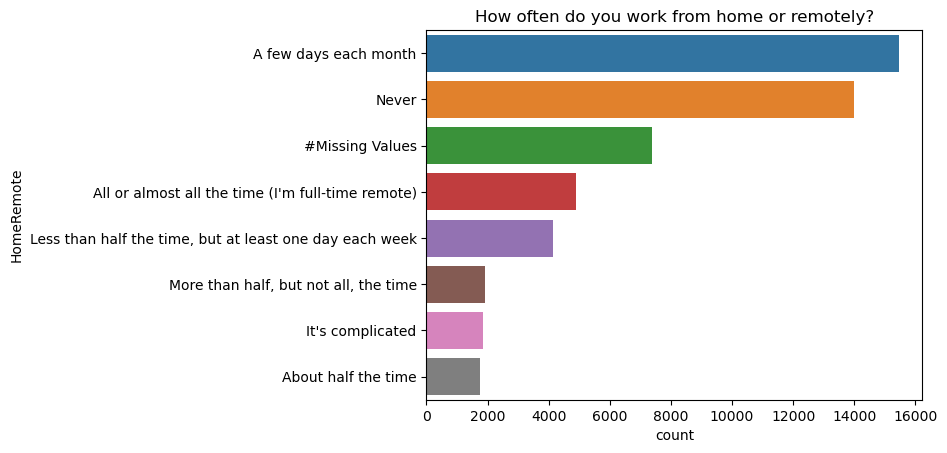

In [8]:
# Overview over missing values and counts for each answer option on time of working remotely
my_count_plot(df,df_schema,'HomeRemote')

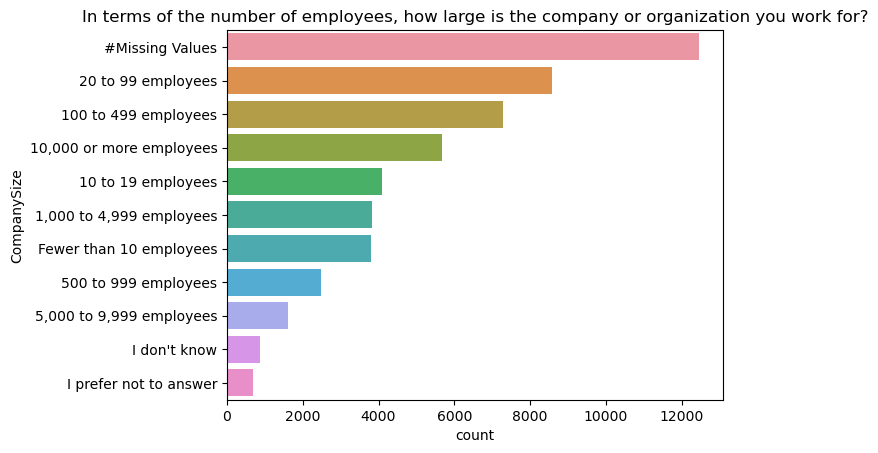

In [9]:
# Overview over missing values and counts for each answer option on company size
my_count_plot(df,df_schema,'CompanySize')

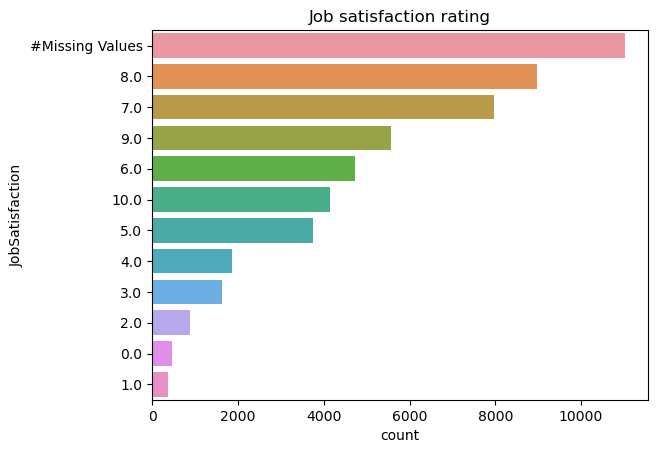

In [10]:
# Overview over missing values and counts for each Job satisfaction rating
my_count_plot(df,df_schema,'JobSatisfaction')

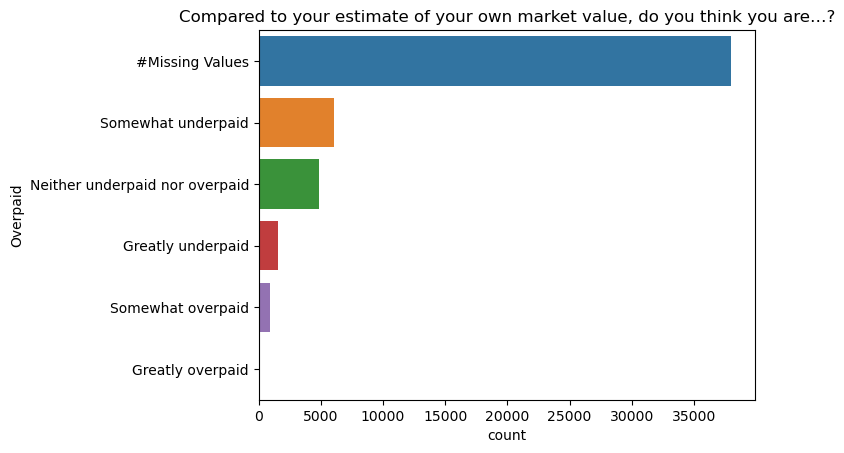

In [11]:
# Overview over missing values and counts for each answer option on subjective overpayment
my_count_plot(df,df_schema,'Overpaid')


<a id='dp'></a>
### Data Preparation

In [12]:
def define_remote(df):
    '''
    
    Return a dataframe with remote working times seperate into <50% and >=50
    
    Parameters:
    df: a raw data dataframe 
    
    Returns:
    df: a dataframe with a new column RemoteTimes
    
    '''
    #drop missing values in column 'HomeRemote'
    df=df[df.HomeRemote.isna()==False]
    
    # seperate HomeRemote in 3 sessions ('less_than_half', 'half_and_more', 'complicated' )
    less_than_half = ['A few days each month', 'Never', 'Less than half the time, but at least one day each week']
    
    half_and_more = ['All or almost all the time (I\'m full-time remote)', 'More than half, but not all, the time', 'About half the time']
    
    
    df['remote_proportion'] = df['HomeRemote'].apply(lambda x: 'less than Half' if x in less_than_half else ('Half and more' if x in half_and_more else 'It\'s complicated'))
    
    # create categorical columns 
    df['remote_under50']=df['remote_proportion'].apply(lambda x: True if x=='less than Half' else False)
    df['remote_overeq50']=df['remote_proportion'].apply(lambda x: True if x=='Half and more' else False)
    return df
                                                                   

In [18]:
def define_relevant_countries(df):
    '''
    
    Return a dataframe with countries with 200 and more programmers listed in dataframe
    
    Parameters:
    df: a raw data dataframe 
    
    Returns:
    df: a new dataframe reduced to country values
    
    '''
    #drop countries with less than 200 programmers listed
    countries = (df.Country.value_counts()>=200)
    loC = countries[countries].index
    
    df=df[df.Country.isin(loC)]
    
    return df

In [20]:
df_remote=define_remote(df)
df_modC=define_relevant_countries(df_remote)
df_country=pd.DataFrame(df_modC.groupby(['Country']).mean(),columns=['remote_under50','remote_overeq50']).sort_values('remote_overeq50', ascending=False)
df_country.head(20)

,remote_under50,remote_overeq50
Country,,
Indonesia,0.613734,0.356223
Pakistan,0.626404,0.353933
Iran,0.632701,0.353081
Philippines,0.644628,0.314050
Russian Federation,0.673028,0.300254
Ukraine,0.679245,0.295597
Argentina,0.716895,0.251142
Serbia,0.732673,0.247525
Czech Republic,0.717808,0.243836


In [21]:
df_company=pd.DataFrame(df_remote.groupby(['CompanySize']).mean(),columns=['remote_under50','remote_overeq50']).sort_values('remote_overeq50', ascending=False)
df_company

,remote_under50,remote_overeq50
CompanySize,,
Fewer than 10 employees,0.696818,0.265054
I don't know,0.766821,0.182135
10 to 19 employees,0.777425,0.176643
I prefer not to answer,0.808889,0.155556
20 to 99 employees,0.828728,0.123936
100 to 499 employees,0.845826,0.109889
"5,000 to 9,999 employees",0.861423,0.103620
"10,000 or more employees",0.861449,0.099418
"1,000 to 4,999 employees",0.854868,0.097364


In [25]:
df_satisfied=pd.DataFrame(df_remote.groupby(['remote_proportion']).mean(),columns=['JobSatisfaction','CareerSatisfaction']).sort_values('JobSatisfaction', ascending=False)
df_satisfied

,JobSatisfaction,CareerSatisfaction
remote_proportion,,
Half and more,7.212068,7.552201
less than Half,6.902825,7.329328
It's complicated,6.840830,7.289413


In [28]:
df_salary=pd.DataFrame(df_remote.groupby(['remote_proportion']).mean(),columns=['Salary','ExpectedSalary']).sort_values('Salary', ascending=False)
df_salary

,Salary,ExpectedSalary
remote_proportion,,
Half and more,66214.622796,35323.461254
It's complicated,55742.095768,38007.414166
less than Half,54871.518153,35392.901723


<a id='dm'></a>
### Data Modeling

<a id='re'></a>
### Result Evaluation

<a id='dep'></a>
### Deployment